# RSRS Trading Strategy

# Zhiwei (William) He

#### Resistance Level
Resistance level refers to a price point at which the asset's price encounters selling pressure, preventing it from rising further. It is believed to reflect the opening of selling forces, making it difficult for prices to rise. Investors predict more sellers will enter the market at this level, increasing supply and causing prices to halt or decline.

#### Support Level
Definition: Support level refers to a price point at which the asset's price encounters buying pressure, preventing it from falling further. It is believed to reflect the opening of buying forces, making it difficult for prices to decline. Investors predict more buyers will enter the market at this level, increasing demand and causing prices to halt or rise.

#### Limitations of Traditional Resistance and Support Levels
1. Lagging Nature: Traditional indicators of resistance and support levels have a lagging nature, making strategies based on them vulnerable during volatile market conditions.
2. Fixed Value Use: Using fixed values for support and resistance levels does not account for the dynamic and changing nature of the market.


## Resistance Support Relative Strength (RSRS): A New Indicator for Resistance and Support
#### Concept of RSRS
RSRS (Resistance Support Relative Strength) is a technical indicator developed to overcome the limitations of traditional resistance and support levels by quantifying the relative strength of these levels to predict future market trends. Instead of viewing resistance and support levels as fixed price ranges, RSRS treats them as dynamic values, capturing their relative changes and providing a more adaptive approach to market analysis.

1. Import Library

In [31]:
import akshare as ak
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib as mpl
import yfinance as yf

2. Import Data

For this trading strategy, we will be using  CSI 300 Index, which is index comprised of 300 largest value firm in China

In [2]:
# 深证100 (Shenzhen 100 Index)
shenzhen_100 = ak.stock_zh_index_daily(symbol='sz399004')

# 上证50 (SSE 50 Index)
sse_50 = ak.stock_zh_index_daily(symbol='sh000016')

# 深证中小创新指数 (ChiNext Index)
chinext_index = ak.stock_zh_index_daily(symbol='sz399606')

# 沪深300 (CSI 300 Index)
chinext_index = ak.stock_zh_index_daily(symbol='sh000300')

In [657]:
index_code = 'sz399004'
start_date = pd.to_datetime("2021-05-31")
end_date = pd.to_datetime("2024-05-31")
price_df = ak.stock_zh_index_daily(symbol = index_code)
price_df['date'] = pd.to_datetime(price_df['date'])
price_df = price_df[(price_df['date']>= start_date) & (price_df['date']<= end_date)]
price_df = price_df.set_index('date')

In [392]:
price_df = yf.download("^RUT", start = start_date, end = end_date)

[*********************100%%**********************]  1 of 1 completed


3. Compute RSRS Index

 The computation of RSRS involves several steps. First, a time window 
𝑁
N is defined to capture the highest and lowest prices within this period. Using these high and low prices, a linear regression model is constructed where the high prices are the dependent variable and the low prices are the independent variable. The slope (
𝛽
β) of this regression line represents the RSRS value for that time window. In adidtion, we also perform weight least square using time and trading volume

In [658]:

# Number of observations to use for the rolling window calculation
Number_Observation = 15

# Initialize arrays with NaN values to store the results of beta and R-squared
beta = np.full(price_df.shape[0], np.nan)
r_squared = np.full(price_df.shape[0], np.nan)

# Loop over the DataFrame, starting from the index equal to Number_Observation
for i in range(Number_Observation, len(price_df)):
    # Define the dependent variable (y) as the 'high' prices over the rolling window
    y = price_df['high'].iloc[i - Number_Observation:i].values
    
    # Define the independent variable (X) as a combination of a column of ones and 'low' prices over the rolling window
    X = np.c_[np.ones(Number_Observation), price_df['low'].iloc[i - Number_Observation:i].values]
    
    # Create a linear regression model and fit it to the data
    model = LinearRegression()
    model.fit(X, y)
    
    # Store the beta coefficient of the 'low' variable (second column in X) in the beta array
    beta[i - 1] = model.coef_[1]
    
    # Store the R-squared value of the model in the r_squared array
    r_squared[i - 1] = model.score(X, y)

# Add the beta and R-squared values as new columns to the DataFrame
price_df['rsrs_beta'] = beta
price_df['r_squared'] = r_squared

# Drop rows with NaN values (the initial rows where the rolling window was not fully populated)
#price_df = price_df.dropna()

In [659]:
# Weight Least Square Using Time 

def calculate_weights(N):
    weights = np.array([(N - i) / (N + 1) * 2 / N for i in range(N)])
    return weights

# Initialize arrays to store beta and R-squared values
beta = np.full(price_df.shape[0], np.nan)
r_squared = np.full(price_df.shape[0], np.nan)

# Loop over the DataFrame starting from the index equal to Number_Observation
for i in range(Number_Observation, len(price_df)):
    # Define the dependent variable (y) and independent variable (X)
    y = price_df['high'].iloc[i - Number_Observation:i].values
    X = price_df['low'].iloc[i - Number_Observation:i].values
    X = np.c_[np.ones(Number_Observation), X]  # Add a column of ones for the intercept

    # Calculate weights
    weights = calculate_weights(Number_Observation)

    # Fit the weighted linear regression model
    model = LinearRegression()
    model.fit(X, y, sample_weight=weights)
    
    # Store the beta coefficient of the 'low' variable
    beta[i] = model.coef_[1]
    
    # Store the R-squared value of the model
    r_squared[i] = model.score(X, y, sample_weight=weights)

# Add the beta and R-squared values as new columns to the DataFrame
price_df['Time_Weight_rsrs_beta'] = beta
price_df['Time_Weight_r_squared'] = r_squared

# Drop rows with NaN values
price_df = price_df.dropna()

#price_df.head()

In [660]:
# Weight Least Square Using 
beta = np.full(price_df.shape[0], np.nan)
r_squared = np.full(price_df.shape[0], np.nan)

# Loop over the DataFrame starting from the index equal to Number_Observation
for i in range(Number_Observation, len(price_df)):
    # Define the dependent variable (y) and independent variable (X)
    y = price_df['high'].iloc[i - Number_Observation:i].values
    X = price_df['low'].iloc[i - Number_Observation:i].values
    X = np.c_[np.ones(Number_Observation), X]  # Add a column of ones for the intercept

    # Calculate weights
    weights = price_df['volume'].iloc[i - Number_Observation:i].values

    # Fit the weighted linear regression model
    model = LinearRegression()
    model.fit(X, y, sample_weight=weights)
    
    # Store the beta coefficient of the 'low' variable
    beta[i] = model.coef_[1]
    
    # Store the R-squared value of the model
    r_squared[i] = model.score(X, y, sample_weight=weights)

# Add the beta and R-squared values as new columns to the DataFrame
price_df['Volume_Weight_rsrs_beta'] = beta
price_df['Volume_Weight_r_squared'] = r_squared

# Drop rows with NaN values
#price_df = price_df.dropna()

#price_df.head()

4. Standardize RSRS

To enhance the indicator’s reliability, the raw RSRS values are standardized by calculating their z-scores over a period 
𝑀
M. The standardized RSRS values can be further adjusted by incorporating the R-squared (
𝑅^2
 ) value of the regression model, which reflects the goodness of fit, resulting in the Adjusted RSRS. Additionally, the Adjusted RSRS can be skewed to emphasize upward market movements, known as Right-Skewed RSRS.

In [661]:
# Define the window size for the rolling calculation
window_M = 100

# Calculate the rolling mean of the 'rsrs_beta' column over the specified window
rolling_mean = price_df['rsrs_beta'].rolling(window=window_M).mean()

# Calculate the rolling standard deviation of the 'rsrs_beta' column over the specified window
rolling_std = price_df['rsrs_beta'].rolling(window=window_M).std()

# Calculate the Z-score of the 'rsrs_beta' by subtracting the rolling mean and dividing by the rolling standard deviation
price_df['rsrs_zscore'] = (price_df['rsrs_beta'] - rolling_mean) / rolling_std

5.  Adjust the Z_Score Based on the R^2

In [662]:
# Adjust the Z-score based on the R-squared value by multiplying the Z-score with the R-squared value
price_df['Adjusted_RSRS_R2'] = price_df['rsrs_zscore'] * price_df['r_squared']

6. Adjust THE ZSCORE_R^2 for the current trend by multiplying by the current beta

In [663]:
# Adjust the RSRS based on the beta value 
price_df['rsrs_zscore_positive'] = price_df['Adjusted_RSRS_R2'] * price_df['rsrs_beta']

7. Build Trading Strategy

In [664]:
price_df.columns
Indicator = ['rsrs_beta','Time_Weight_rsrs_beta','Volume_Weight_rsrs_beta',\
             'rsrs_zscore','Adjusted_RSRS_R2', 'rsrs_zscore_positive']
Indicator

['rsrs_beta',
 'Time_Weight_rsrs_beta',
 'Volume_Weight_rsrs_beta',
 'rsrs_zscore',
 'Adjusted_RSRS_R2',
 'rsrs_zscore_positive']

In [665]:
rolling_window = 30  # You can adjust this window size based on your preference

def calculate_dynamic_thresholds(df, column, window, std_factor):
    rolling_mean = df[column].rolling(window=window).mean()
    rolling_std = df[column].rolling(window=window).std()
    upper_threshold = rolling_mean + (std_factor * rolling_std)  # Upper threshold
    lower_threshold = rolling_mean - (std_factor * rolling_std)  # Lower threshold
    return upper_threshold, lower_threshold

In [666]:
for i in range(len(Indicator)):
    price_df[f'{Indicator[i]}_upper'], price_df[f'{Indicator[i]}_lower'] = calculate_dynamic_thresholds(price_df, Indicator[i], rolling_window, std_factor = 1.5)

In [667]:
price_df

,open,high,low,close,volume,rsrs_beta,r_squared,Time_Weight_rsrs_beta,Time_Weight_r_squared,Volume_Weight_rsrs_beta,...,Time_Weight_rsrs_beta_upper,Time_Weight_rsrs_beta_lower,Volume_Weight_rsrs_beta_upper,Volume_Weight_rsrs_beta_lower,rsrs_zscore_upper,rsrs_zscore_lower,Adjusted_RSRS_R2_upper,Adjusted_RSRS_R2_lower,rsrs_zscore_positive_upper,rsrs_zscore_positive_lower
date,,,,,,,,,,,,,,,,,,,,,
2021-06-22,9184.381,9203.762,9106.047,9197.615,4481965918,0.935803,0.853984,0.810051,0.775669,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-23,9211.857,9330.024,9156.076,9289.705,4576078941,0.936173,0.836958,0.880034,0.808540,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-24,9317.706,9321.464,9209.954,9276.287,4295622694,0.904472,0.794707,0.895843,0.799743,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-25,9291.456,9464.281,9284.210,9441.293,4635712505,0.941607,0.790746,0.872293,0.764421,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-28,9476.233,9566.678,9461.199,9551.130,4373657083,0.862909,0.841330,0.917201,0.749845,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24,5869.410,5903.842,5811.844,5815.050,3752041050,0.610217,0.761378,0.789673,0.782937,0.723637,...,1.044057,0.649229,1.075500,0.640009,2.164737,-1.764737,1.773442,-1.303612,1.931492,-1.243125
2024-05-27,5823.677,5857.250,5791.644,5853.888,3518622049,0.755401,0.823470,0.590903,0.681683,0.602374,...,1.049240,0.634676,1.079790,0.626246,2.164575,-1.755011,1.772450,-1.293256,1.931005,-1.235359
2024-05-28,5846.329,5846.329,5773.380,5775.838,3839548978,0.855771,0.887972,0.631738,0.673550,0.735000,...,1.051769,0.625349,1.079858,0.625009,2.176846,-1.735595,1.781578,-1.274855,1.936955,-1.218267


In [668]:
# Generate trading signals based on dynamic thresholds
def generate_signals(df, column, upper, lower):
    df[f'{column}_signal'] = np.where(df[column] >= df[upper], 1, np.where(df[column] <= df[lower], -1, np.nan))
    df[f'{column}_signal'] = df[f'{column}_signal'].ffill().fillna(0)
   # df[f'{column}_signal'][df[f'{column}_signal'] < 0] = 0  # Convert -1 to 0 (ignore sell signals)


In [669]:
for i in range(len(Indicator)):
    generate_signals(price_df, Indicator[i], f'{Indicator[i]}_upper', f'{Indicator[i]}_lower')

In [670]:
price_df

,open,high,low,close,volume,rsrs_beta,r_squared,Time_Weight_rsrs_beta,Time_Weight_r_squared,Volume_Weight_rsrs_beta,...,Adjusted_RSRS_R2_upper,Adjusted_RSRS_R2_lower,rsrs_zscore_positive_upper,rsrs_zscore_positive_lower,rsrs_beta_signal,Time_Weight_rsrs_beta_signal,Volume_Weight_rsrs_beta_signal,rsrs_zscore_signal,Adjusted_RSRS_R2_signal,rsrs_zscore_positive_signal
date,,,,,,,,,,,,,,,,,,,,,
2021-06-22,9184.381,9203.762,9106.047,9197.615,4481965918,0.935803,0.853984,0.810051,0.775669,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-23,9211.857,9330.024,9156.076,9289.705,4576078941,0.936173,0.836958,0.880034,0.808540,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-24,9317.706,9321.464,9209.954,9276.287,4295622694,0.904472,0.794707,0.895843,0.799743,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-25,9291.456,9464.281,9284.210,9441.293,4635712505,0.941607,0.790746,0.872293,0.764421,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-28,9476.233,9566.678,9461.199,9551.130,4373657083,0.862909,0.841330,0.917201,0.749845,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24,5869.410,5903.842,5811.844,5815.050,3752041050,0.610217,0.761378,0.789673,0.782937,0.723637,...,1.773442,-1.303612,1.931492,-1.243125,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2024-05-27,5823.677,5857.250,5791.644,5853.888,3518622049,0.755401,0.823470,0.590903,0.681683,0.602374,...,1.772450,-1.293256,1.931005,-1.235359,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2024-05-28,5846.329,5846.329,5773.380,5775.838,3839548978,0.855771,0.887972,0.631738,0.673550,0.735000,...,1.781578,-1.274855,1.936955,-1.218267,-1.0,-1.0,-1.0,-1.0,-1.0,1.0


8. Compute Cumulative Return

In [671]:
price_df['Buy_Hold_Return'] = price_df['close'].pct_change()
price_df['Buy_Hold_Cum_Return'] = np.cumprod(price_df['Buy_Hold_Return'] + 1) - 1

In [672]:
signal_column = ['rsrs_beta_signal', 'Time_Weight_rsrs_beta_signal',
       'Volume_Weight_rsrs_beta_signal', 'rsrs_zscore_signal',
       'Adjusted_RSRS_R2_signal', 'rsrs_zscore_positive_signal']

In [673]:
for i in range(len(signal_column)):
    price_df[f'{Indicator[i]}_Return'] = price_df['Buy_Hold_Return'] * price_df[signal_column[i]]

In [674]:
Return_Column = ['rsrs_beta_Return', 'Time_Weight_rsrs_beta_Return',
       'Volume_Weight_rsrs_beta_Return', 'rsrs_zscore_Return',
       'Adjusted_RSRS_R2_Return', 'rsrs_zscore_positive_Return']

In [675]:
for i in range(len(Return_Column)):
    price_df[f'{Indicator[i]}_Cum_Return'] = np.cumprod(price_df[Return_Column[i]]+1)  -1

In [676]:
price_df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'rsrs_beta', 'r_squared',
       'Time_Weight_rsrs_beta', 'Time_Weight_r_squared',
       'Volume_Weight_rsrs_beta', 'Volume_Weight_r_squared', 'rsrs_zscore',
       'Adjusted_RSRS_R2', 'rsrs_zscore_positive', 'rsrs_beta_upper',
       'rsrs_beta_lower', 'Time_Weight_rsrs_beta_upper',
       'Time_Weight_rsrs_beta_lower', 'Volume_Weight_rsrs_beta_upper',
       'Volume_Weight_rsrs_beta_lower', 'rsrs_zscore_upper',
       'rsrs_zscore_lower', 'Adjusted_RSRS_R2_upper', 'Adjusted_RSRS_R2_lower',
       'rsrs_zscore_positive_upper', 'rsrs_zscore_positive_lower',
       'rsrs_beta_signal', 'Time_Weight_rsrs_beta_signal',
       'Volume_Weight_rsrs_beta_signal', 'rsrs_zscore_signal',
       'Adjusted_RSRS_R2_signal', 'rsrs_zscore_positive_signal',
       'Buy_Hold_Return', 'Buy_Hold_Cum_Return', 'rsrs_beta_Return',
       'Time_Weight_rsrs_beta_Return', 'Volume_Weight_rsrs_beta_Return',
       'rsrs_zscore_Return', 'Adjusted_RSRS_R2_Return',
 

In [677]:
Cum_Return_Column = ["Buy_Hold_Cum_Return",'rsrs_beta_Cum_Return',
       'Time_Weight_rsrs_beta_Cum_Return',
       'Volume_Weight_rsrs_beta_Cum_Return', 'rsrs_zscore_Cum_Return',
       'Adjusted_RSRS_R2_Cum_Return', 'rsrs_zscore_positive_Cum_Return']

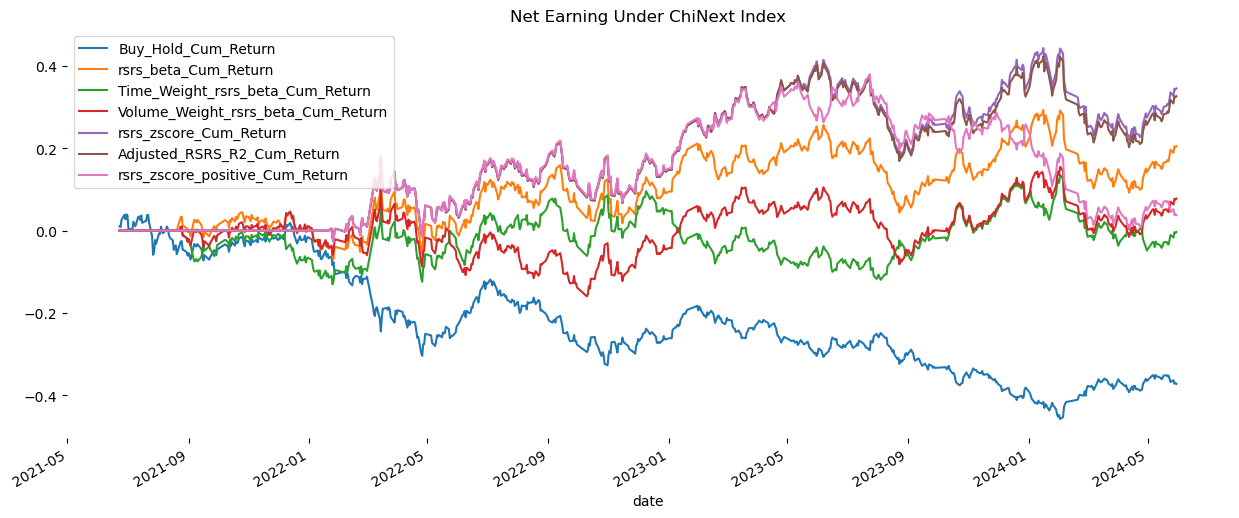

In [678]:
ax = price_df[Cum_Return_Column].plot(figsize = (15,6), title = "Net Earning Under ChiNext Index")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

In [612]:
 price_df[Cum_Return_Column]

,Buy_Hold_Cum_Return,rsrs_beta_Cum_Return,Time_Weight_rsrs_beta_Cum_Return,Volume_Weight_rsrs_beta_Cum_Return,rsrs_zscore_Cum_Return,Adjusted_RSRS_R2_Cum_Return,rsrs_zscore_positive_Cum_Return
date,,,,,,,
2021-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-25,-0.004112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-11-26,-0.011498,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-11-29,-0.013268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-11-30,-0.017213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2024-05-23,-0.259295,0.185838,-0.175097,0.115380,-0.024531,-0.032010,-0.126364
2024-05-24,-0.267495,0.198966,-0.165965,0.127728,-0.013732,-0.021293,-0.136035
2024-05-27,-0.260533,0.187569,-0.173893,0.117008,-0.023107,-0.030596,-0.127823


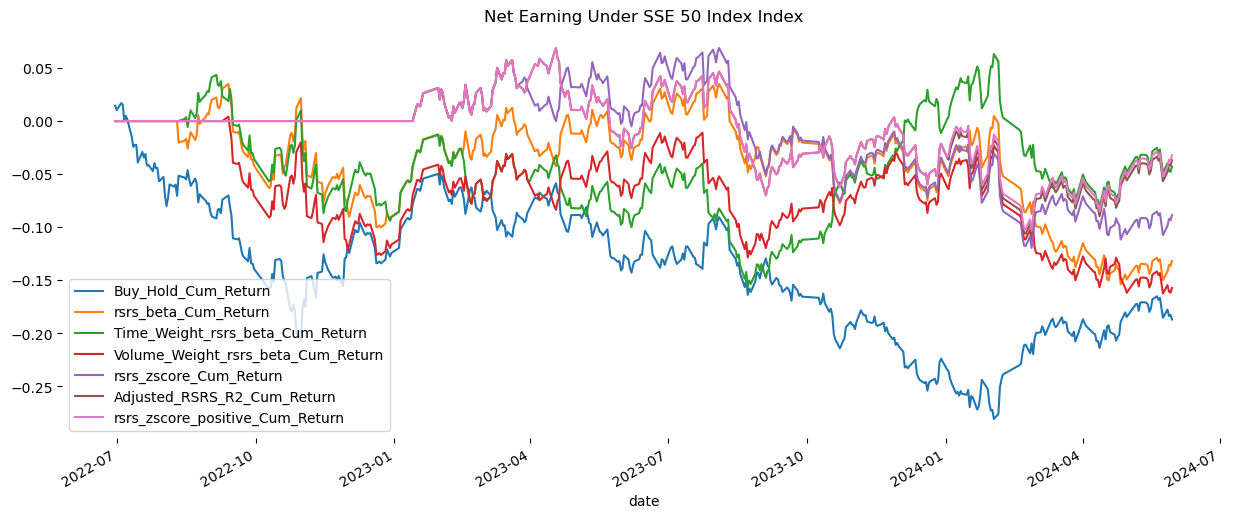

In [307]:
ax = price_df[Cum_Return_Column].plot(figsize = (15,6), title = "Net Earning Under SSE 50 Index Index")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

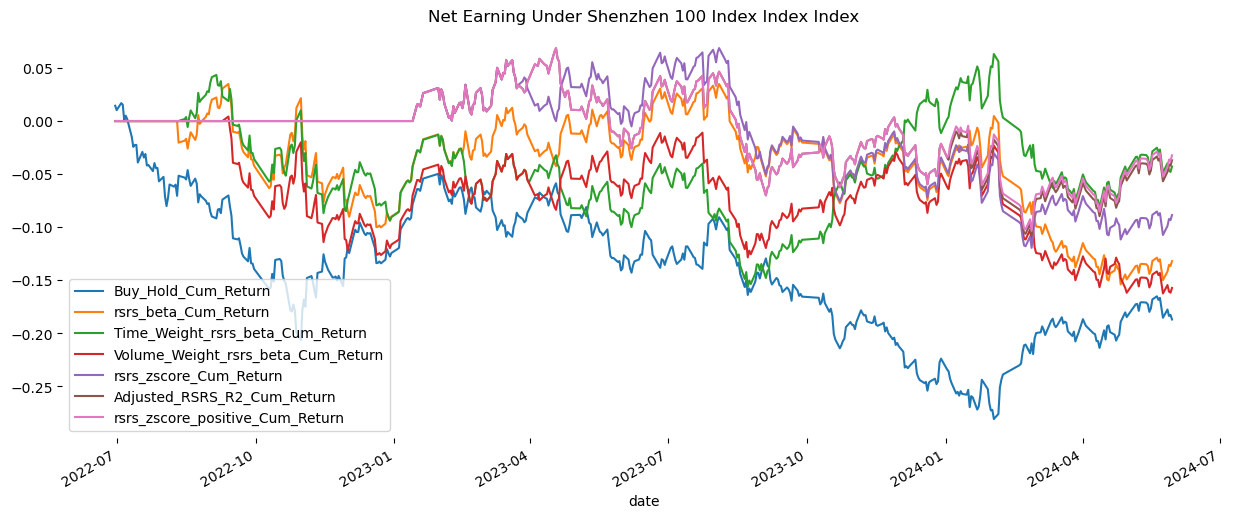

In [308]:
ax = price_df[Cum_Return_Column].plot(figsize = (15,6), title = "Net Earning Under Shenzhen 100 Index Index Index")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)